# Problema del camino más corto

### Funciones auxiliares

In [1]:
from math import log
from random import randint
from timeit import repeat

import matplotlib.pyplot as plt
import networkx as nx
import random
import sys

%matplotlib inline

In [2]:
def is_valid_edge(generated_edges: dict, i: int, j: int):
    return i != j and not generated_edges.get((i, j), None) and not generated_edges.get((j, i), None)

In [3]:
def instance_generator(n: int):
    """
        Input: cantidad de vértices
        Output: una lista que contiene todos los arcos y el número del vértice fuente (la función retorna dos variables).
        Los arcos vienen en la forma (i, j, weight), donde i es el vértice origen del arco y j el vértice al que apunta el arco, mientras que weight es su peso.
    """
    graph = []
    nodes = random.sample(range(0, n), n)
    unvisited_nodes = random.sample(range(0, n), n)
    
    generated_edges = {}
    for i in nodes:
        rand = random.sample(nodes, random.randint(1, 3))

        for j in rand:
            edge = (i, j)
            edge_with_weight = (i, j, random.randint(1, 50))
            
            if generated_edges.get((edge[1], edge[0]), None):
                continue
            
            if i == j:
                new_vertice = None
                iterations = 0
                while new_vertice is None and iterations < 250:
                    iterations += 1
                    number = random.randint(0, n - 1)
                    if is_valid_edge(generated_edges, i, number):
                        new_vertice = number

                if iterations >= 250:
                    return instance_generator(n)
                
                edge = (i, new_vertice)
                edge_with_weight = (i, new_vertice, random.randint(-50, 50)) # -25 y 100 corresponde a los límites de los pesos, puede cambiarlos.
            
            graph.append(edge_with_weight)
            generated_edges[edge] = edge

            if edge_with_weight[1] in unvisited_nodes:
                unvisited_nodes.remove(edge_with_weight[1])

    for i in unvisited_nodes:
        valid_edge = False
        iterations = 0
        while not valid_edge and iterations < 250:
            iterations += 1
            m = random.randint(0, n - 1)
            if is_valid_edge(generated_edges, m, i):
                valid_edge = True
                edge = (m, i)
                edge_with_weight = (m, i, random.randint(-50, 50)) # -25 y 100 corresponde a los límites de los pesos, puede cambiarlos.
                graph.append(edge_with_weight)
                generated_edges[edge] = edge

        if iterations >= 250:
            return instance_generator(n)

    return graph, graph[0][0]

In [4]:
def instance_generator_positive(n: int):
    """
        Input: cantidad de vértices
        Output: una lista que contiene todos los arcos y el número del vértice fuente (la función retorna dos variables).
        Los arcos vienen en la forma (i, j, weight), donde i es el vértice origen del arco y j el vértice al que apunta el arco, mientras que weight es su peso.
    """
    graph = []
    nodes = random.sample(range(0, n), n)
    unvisited_nodes = random.sample(range(0, n), n)
    
    generated_edges = {}
    for i in nodes:
        rand = random.sample(nodes, random.randint(1, 3))

        for j in rand:
            edge = (i, j)
            edge_with_weight = (i, j, random.randint(1, 50))
            
            if generated_edges.get((edge[1], edge[0]), None):
                continue
            
            if i == j:
                new_vertice = None
                iterations = 0
                while new_vertice is None and iterations < 250:
                    iterations += 1
                    number = random.randint(0, n - 1)
                    if is_valid_edge(generated_edges, i, number):
                        new_vertice = number

                if iterations >= 250:
                    return instance_generator(n)
                
                edge = (i, new_vertice)
                edge_with_weight = (i, new_vertice, random.randint(1, 50)) # 1 y 50 corresponde a los límites de los pesos, puede cambiarlos.
            
            graph.append(edge_with_weight)
            generated_edges[edge] = edge

            if edge_with_weight[1] in unvisited_nodes:
                unvisited_nodes.remove(edge_with_weight[1])

    for i in unvisited_nodes:
        valid_edge = False
        iterations = 0
        while not valid_edge and iterations < 250:
            iterations += 1
            m = random.randint(0, n - 1)
            if is_valid_edge(generated_edges, m, i):
                valid_edge = True
                edge = (m, i)
                edge_with_weight = (m, i, random.randint(1, 50)) # 1 y 50 corresponde a los límites de los pesos, puede cambiarlos.
                graph.append(edge_with_weight)
                generated_edges[edge] = edge

        if iterations >= 250:
            return instance_generator(n)

    return graph, graph[0][0]

In [5]:
def list_to_adj_matrix(graph_list, n):
    """
        Input: Un grafo en formato list[tuple].
        Ej: [(x1, y1, peso1), (x2, y2, peso2), ...].
        Output: Matriz de adyacencia del grafo.
    """
    m = len(graph_list)
    adjMat = [[0 for i in range(n)]for j in range(n)]
    for _ in range(m):
        for (x, y, peso) in g2:
            adjMat[x][y] = peso
    return adjMat

In [6]:
def graph_to_nxdigraph(graph: list, n: int):
    """
        Input: Un grafo en formato list[tuple].
        Ej: [(0, 1, 10), (1, 2, 15), (2, 0, 7)].
        Output: Un nx.DiGraph de la libreria networkx.
    """
    nxdigraph = nx.DiGraph()
    [nxdigraph.add_node(i) for i in range(n)]

    for v in graph:
        nxdigraph.add_edge(v[0], v[1], weight=v[2])

    return nxdigraph

In [7]:
def visualize_graph(lista_grafo, n):
    """
        Input: Un grafo en formato list[tuple].
        Ej: [(x1, y1, peso1), (x2, y2, peso2), ...].
        Output: No retorna nada. Imprime el grafo.
    """
    grafoNX = graph_to_nxdigraph(lista_grafo, n)
    pos = nx.circular_layout(grafoNX)
    labels = nx.get_edge_attributes(grafoNX, 'weight')

    nx.draw_networkx(grafoNX, pos)
    nx.draw_networkx_edge_labels(grafoNX, pos, edge_labels=labels)
    plt.show()

## 1. Algoritmo de Bellman-Ford

### 1.1. Descripción del algoritmo

El algoritmo de Bellman-Ford resuleve el problema de optimización de encontrar el camino más corto de un grafo dirigido con $n$ nodos.

El grafo puede contener arcos con costo negativo, por lo que éste puede entregar 2 resultados: el camino más corto o que el grafo contiene u ciclo negativo, así que no existe un camino más corto.

**Entrada**: Grafo G con $n$ nodos y el nodo de inicio.

**Salida**: Valor del camino más corto desde el nodo inicial hasta el resto de los nodos.

Se genera una lista en la que se almacenarán los costos totales de los caminos desde el nodo inicial hasta cada uno de los nodos del grafo y se inicializa el raíz en 0 y el resto en infinito.

Se repite el cálculo $|V|-1$ veces, porque es el máximo número de arcos que se pueden usar para armar el camino más corto.

Por cada iteración se calcula el valor del arco más el del nodo anterior (0 para el nodo raíz) y si es menor que el valor del nodo del que se está calculando, se actualiza.

Luego de haber terminado de calcular, se repite el proceso para detectar posibles ciclos negativos. Si se puede reducir de nuevo algún valor, entonces existe un ciclo negativo y el algoritmo retorna un mensaje indicándolo y la lista de distancias vacía.

In [8]:
class GraphBF():
 
    def __init__(self, vertices):
        self.V = vertices  # No. de vértices
        self.graph = list()
 
    # Función para agregar aristas al grafo
    def addEdge(self, u, v, w):
        self.graph.append((u, v, w))
 
    # Función para imprimir los resultados
    def printArr(self, dist):
        print("Vertex Distance from Source")
        for i in range(self.V):
            print("{0}\t\t{1}".format(i, dist[i]))

    # Función que calcula las distancias más cortas desde un nodo raíz hasta
    # los demás nodos del grafo. La función también detecta ciclos negativos.
    def BellmanFord(self, src, verbose=False, visualize=False, print_solution=True):

        # Se inicializan las distancias en 0 para el nodo raíz y en infinito
        # para todo el resto de nodos
        dist = [float("Inf")] * self.V
        dist[src] = 0
        if verbose:
            print(f'Inicializando arreglo de distancias...')
            print(dist, '\n')

        # Se aplica la función relax V-1 veces (el camino simple más corto
        # puede tener a lo más V-1 aristas)
        for o in range(self.V - 1):
            # Se calcula el valor de la distancia
            for u, v, w in self.graph:
                if dist[u] != float("Inf") and dist[u] + w < dist[v]:
                    dist[v] = dist[u] + w
            if verbose:
                print(f'Arreglo de distancias en iteración {o+1}: {dist}')

        # Bucle para buscar ciclos negativos. El paso anterior garantiza las
        # distancias más cortas posibles del grafo si éste no contiene ciclos
        # negativos. Si este bucle encuentra un camino más corto que el obtenido
        # antes, entonces existe un ciclo negativo y retorna una lista vacía.
        if verbose:
            print("\nBuscando ciclos negativos...")
        for u, v, w in self.graph:
            if dist[u] != float("Inf") and dist[u] + w < dist[v]:
                if print_solution:
                    print("El grafo contiene un ciclo negativo")
                dist = list()
                return dist

        if verbose:
            print()
        if print_solution:
            print("No existen ciclos negativos\n")
            self.printArr(dist)
        if visualize:
            visualize_graph(self.graph, self.V)

In [9]:
n = 5
g, root = instance_generator(n)
#print(g, root, n)
grafo = GraphBF(n)
for (x, y, peso) in g:
    grafo.addEdge(x, y, peso)
grafo.BellmanFord(root)

No existen ciclos negativos

Vertex Distance from Source
0		-10
1		25
2		13
3		15
4		0


## 2. Algoritmo de Dijkstra

### 2.1. Descripción del algoritmo

El algoritmo de Dijkstra resuelve el problema de optimización de encontrar el camino más corto para grafos dirigidos con $n$ nodos.

**Entrada**: Grafo G con $n$ nodos y el nodo de inicio.

**Salida**: Valor del camino más corto desde el nodo raíz hasta el resto de los nodos del grafo.

Se crea la lista de distancias y se inicializan sus valores en 0 para el nodo raíz e infinito para el resto.

Luego se escoge el mínimo camino del conjunto de nodos no visitados y lo agrega al árbol de recorrido.

Actualiza la lista de distancias si el nuevo nodo no está en el árbol de recorrido.

In [10]:
class GraphD():
 
    def __init__(self, vertices):
        self.V = vertices # No. de vértices
        self.graph = [[0 for column in range(vertices)] for row in range(vertices)]
        self.aristas = list()

    # Función para agregar aristas al grafo
    def addEdge(self, u, v, w):
        self.aristas.append((u, v, w))
 
    # Función para imprimir los resultados
    def printSolution(self, dist):
        print("Vertex Distance from Source")
        for node in range(self.V):
            print(node, "\t", dist[node])

    # Función que permite encontrar el nodo con el mínimo valor de distancia del
    # conjunto de nodos aún no incluídos en el árbol de caminos cortos.
    def minDistance(self, dist, sptSet):
        min = float("Inf")
 
        for u in range(self.V):
            if dist[u] < min and sptSet[u] == False:
                min = dist[u]
                min_index = u
 
        return min_index

    # Función que calcula las distancias más cortas desde un nodo raíz hasta los
    # demás nodos del grafo representado como matriz de adyacencia
    def Dijkstra(self, src, verbose=False, visualize=False, print_solution=True):
 
        dist = [float("Inf")] * self.V
        dist[src] = 0
        sptSet = [False] * self.V
        if verbose:
            print(f'Inicializando arreglo de distancias...')
            print(dist, '\n')
 
        for o in range(self.V):

            # Escoge el nodo con la mínima distancia del conjunto de nodos aún
            # no procesados
            try:
                x = self.minDistance(dist, sptSet)
            except:
                x = -1

            # Agrega el nodo con distancia mínima el árbol de caminos cortos
            sptSet[x] = True

            # Actualiza el valor de la distancia de los nodos adyacentes del
            # nodo actual solo si la distancia actual es mayor que la nueva
            # distancia calculada y el nodo no está en el árbol de caminos cortos
            for y in range(self.V):
                if self.graph[x][y] > 0 and sptSet[y] == False and \
                        dist[y] > dist[x] + self.graph[x][y]:
                    dist[y] = dist[x] + self.graph[x][y]
            if verbose:
                print(f'Arreglo de distancias en iteración {o+1}: {dist}')
        if verbose:
            print()
        if print_solution:
            self.printSolution(dist)
        if visualize:
            visualize_graph(self.aristas, self.V)

In [11]:
n2 = 5
g2, root2 = instance_generator_positive(n2)
adjMat = list_to_adj_matrix(g2, n2)
grafo2 = GraphD(n2)

grafo2.graph = adjMat
grafo2.Dijkstra(root2)

Vertex Distance from Source
0 	 3
1 	 31
2 	 45
3 	 0
4 	 24


## 3. Opción `visualize=True`

No existen ciclos negativos

Vertex Distance from Source
0		24
1		14
2		73
3		31
4		14
5		31
6		12
7		-6
8		0
9		5


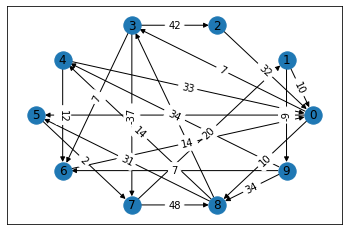

In [12]:
n = 10
g, root = instance_generator(n)
#print(g, root, n)
grafo = GraphBF(n)
for (x, y, peso) in g:
    grafo.addEdge(x, y, peso)
grafo.BellmanFord(root, False, True)

Vertex Distance from Source
0 	 115
1 	 104
2 	 61
3 	 143
4 	 27
5 	 135
6 	 0
7 	 41
8 	 136
9 	 53


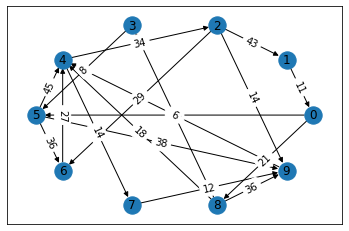

In [13]:
n2 = 10
g2, root2 = instance_generator_positive(n2)
m = len(g2)
adjMat = list_to_adj_matrix(g2, n2)
grafo2 = GraphD(n2)

for (x, y, peso) in g2:
    grafo2.addEdge(x, y, peso)

grafo2.graph = adjMat
grafo2.Dijkstra(root2, False, True)

## 4. Opción `verbose=True`

In [14]:
n = 10
g, root = instance_generator(n)
#print(g, root, n)
grafo = GraphBF(n)
for (x, y, peso) in g:
    grafo.addEdge(x, y, peso)
grafo.BellmanFord(root, True)

Inicializando arreglo de distancias...
[inf, inf, inf, inf, 0, inf, inf, inf, inf, inf] 

Arreglo de distancias en iteración 1: [inf, inf, 40, inf, 0, 87, inf, inf, inf, 86]
Arreglo de distancias en iteración 2: [91, inf, 40, 132, 0, 87, inf, inf, 114, 86]
Arreglo de distancias en iteración 3: [91, inf, 40, 132, 0, 87, inf, inf, 114, 86]
Arreglo de distancias en iteración 4: [91, inf, 40, 132, 0, 87, inf, inf, 114, 86]
Arreglo de distancias en iteración 5: [91, inf, 40, 132, 0, 87, inf, inf, 114, 86]
Arreglo de distancias en iteración 6: [91, inf, 40, 132, 0, 87, inf, inf, 114, 86]
Arreglo de distancias en iteración 7: [91, inf, 40, 132, 0, 87, inf, inf, 114, 86]
Arreglo de distancias en iteración 8: [91, inf, 40, 132, 0, 87, inf, inf, 114, 86]
Arreglo de distancias en iteración 9: [91, inf, 40, 132, 0, 87, inf, inf, 114, 86]

Buscando ciclos negativos...

No existen ciclos negativos

Vertex Distance from Source
0		91
1		inf
2		40
3		132
4		0
5		87
6		inf
7		inf
8		114
9		86


In [15]:
n2 = 10
g2, root2 = instance_generator_positive(n2)
m = len(g2)
adjMat = list_to_adj_matrix(g2, n2)
grafo2 = GraphD(n2)
grafo2.graph = adjMat
grafo2.Dijkstra(root2, True)

Inicializando arreglo de distancias...
[inf, inf, inf, inf, inf, 0, inf, inf, inf, inf] 

Arreglo de distancias en iteración 1: [36, inf, inf, 31, inf, 0, 6, inf, inf, inf]
Arreglo de distancias en iteración 2: [36, inf, inf, 31, inf, 0, 6, 50, inf, 26]
Arreglo de distancias en iteración 3: [36, 45, inf, 31, inf, 0, 6, 50, inf, 26]
Arreglo de distancias en iteración 4: [36, 45, inf, 31, 33, 0, 6, 50, 81, 26]
Arreglo de distancias en iteración 5: [36, 45, 76, 31, 33, 0, 6, 50, 81, 26]
Arreglo de distancias en iteración 6: [36, 45, 76, 31, 33, 0, 6, 50, 81, 26]
Arreglo de distancias en iteración 7: [36, 45, 76, 31, 33, 0, 6, 50, 81, 26]
Arreglo de distancias en iteración 8: [36, 45, 51, 31, 33, 0, 6, 50, 81, 26]
Arreglo de distancias en iteración 9: [36, 45, 51, 31, 33, 0, 6, 50, 81, 26]
Arreglo de distancias en iteración 10: [36, 45, 51, 31, 33, 0, 6, 50, 81, 26]

Vertex Distance from Source
0 	 36
1 	 45
2 	 51
3 	 31
4 	 33
5 	 0
6 	 6
7 	 50
8 	 81
9 	 26


## 5. Correctitud algoritmo de Bellman-Ford

**Teorema**: _Si un grafo $G=(V, E)$ no contiene ciclos negativos, entonces el algoritmo retorna correctamente la distancia mínima desde un nodo inicial hasta cada otro nodo de G._

**Inducción**: _Luego de la iteración $i$, $v.d$ es a lo más el peso de cada camino desde el nodo inicial hasta $v$, usando a lo más $i$ aristas, $\forall v \in V$._

Antes de la iteración $i$, $v.d \leq \min{\left\{w(p): |p| \leq i-1 \right\}}$, donde $|p|$ corresponde a la cantidad de aristas de p.

La función _relaxation_ solo puede igualar o disminuir el valor de $v.d$, por lo que se mantiene verdadero.

La iteración $i$ considera todos los caminos con igual o menor cantidad de aristas que $i$ al aplicar _relax_ sobre las nuevas aristas.

Por lo tanto, se demuestra que el algoritmo computa correctamente el camino más corto para grafos sin ciclos negativos.

## 6. Complejidad temporal para ambos algoritmos

El algoritmo de Bellman-Ford tiene complejidad temporal $O(V \cdot E)$: $O(V)$ para inicializar los valores de la lista de costos, $O(V \cdot E)$ para la ejecución de la función _relax_ y $O(E)$ para el bucle que revisa si existen ciclos negativos.

$T(n) = O(V) + O(V \cdot E) + O(E) = O(V \cdot E)$

El algoritmo de Dijkstra tiene complejidad temporal $O(V^2)$: el algoritmo tiene 2 bucles _for_ anidados, ambos con rango desde 0 hasta $V$, por lo que la complejidad resulta en $O(V^2)$.

# 7. Experimentos

## 7.1. Timepo de ejecución medio para Bellman-Ford

In [16]:
def experimento(n):
    g, root = instance_generator(n)
    grafo = GraphBF(n)
    for (x, y, peso) in g:
        grafo.addEdge(x, y, peso)
    return grafo.BellmanFord(root, False, False, False)

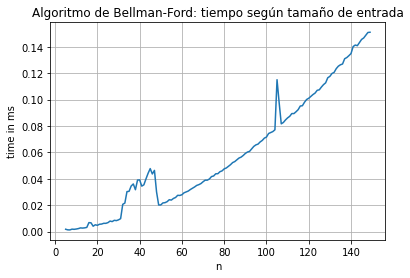

In [17]:
x = []
y = []

times = []

for n in range(5, 150):
    t = repeat(setup="from __main__ import is_valid_edge, instance_generator, GraphBF, experimento", stmt=f'experimento({n})', repeat=25, number=10)
    x.append(n)
    times.append(t)
    
for i in times:
    a = sum(i)
    a = a/25
    y.append(a)

plt.plot(x, y)

plt.xlabel('n')
plt.ylabel('time in ms')
plt.title("Algoritmo de Bellman-Ford: tiempo según tamaño de entrada")

plt.grid()
plt.show()

Como se aprecia en el gráfico, la curva tiene un comportamiento cuadrático, que calza con lo demostrado en la sección de complejidad temporal.